In [1]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import copy
import tarfile
import igraph as ig
%matplotlib inline

from planar import create_proximity_graph
from auxiliary import get_base_network_name, load_delta_data
from auxiliary import powerlaw, getLinearReg
from fractal import get_box_count, get_cluster_densities
import mpl_settings_v3
from mpl_settings_v3 import *
import seaborn as sns
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from cycler import cycler

net_type = 'DT'
param = 'param'

net_dir = os.path.join('../networks', net_type)
fig_dir = '../draft/figs'

attack_dict = {
    'Ran': r'$\mathrm{Rnd}$', 'Deg': r'$\mathrm{ID}$', 'DegU': r'$\mathrm{RD}$',
    'Btw': r'$\mathrm{IB}$', 'BtwU': r'$\mathrm{RB}$', 
    'Eigenvector': r'$\mathrm{IE}$', 'EigenvectorU': r'$\mathrm{RE}$',
    'CI': r'$\mathrm{ICI}$', 'CIU': r'$\mathrm{RCI}$', 'CIU2': r'$\mathrm{RCI2}$',
}

for i in range(2, 100):
    attack_dict['BtwU_cutoff{}'.format(i)] = r'$\mathrm{RB}$' + r'${{{}}}$'.format(i)

measures_dict = {
    'Nsec': r'$N_2$',
    'meanS': r'$\langle s \rangle$'
}

letters = [r'$\mathrm{(a)}$', r'$\mathrm{(b)}$', r'$\mathrm{(c)}$', r'$\mathrm{(d)}$',
           r'$\mathrm{(e)}$', r'$\mathrm{(f)}$', r'$\mathrm{(g)}$', r'$\mathrm{(h)}$']

attack_colors = {
    'B': '#27647b', 'D': '#ca3542', 'R': '#57575f', 'E': '#50C878',
    'C': '#80471C', # Brown peanut
    'B3': '#6F2DA8', # Purple
    'B4': '#F05E23' # Orange salamander
}

In [31]:
def load_delta(net_type, size, param, attack, nseeds=None):
    dir_name = os.path.join('../networks', net_type)
    base_net_name, base_net_name_size = get_base_network_name(net_type, size, param)
    net_dir_name = os.path.join(dir_name, base_net_name,
            base_net_name_size
    )
    if nseeds:
        delta_file_name = os.path.join(net_dir_name,
            'Delta_values_' + attack + '_nSeeds{:d}.txt'.format(nseeds)
        )
    else:
        files = [file for file in os.listdir(net_dir_name) if 'Delta' in file]
        file_name = max([file for file in files if attack + '_nSeeds' in file])
        delta_file_name = os.path.join(net_dir_name,
            file_name
        )
    delta_values = np.loadtxt(delta_file_name)
    return delta_values

def average_delta(net_type, param, attack, N_values, nseeds):
    mean_pos_values = []
    std_pos_values = []
    mean_delta_values = []
    std_delta_values = []
    for N in N_values:
        try:
            delta_values = load_delta(net_type, N, param, attack, nseeds)
        except:
            delta_values = load_delta(net_type, N, param, attack, nseeds//10)
        pos, delta = delta_values.mean(axis=0)
        std_pos, std_delta = delta_values.std(axis=0)
        mean_pos_values.append(pos)
        std_pos_values.append(std_pos)
        mean_delta_values.append(delta)
        std_delta_values.append(std_delta)
    return mean_pos_values, std_pos_values, mean_delta_values, std_delta_values

### **Fig. 1 from Fan (2020)**

In [32]:
if False:
    net_type = 'ER'
    param = '3.50'
    attack = 'Ran'
else:
    net_type = 'DT'
    param = 'param'
    attack = 'BtwU'
    
nseeds_per_size = {
    256: 1000,
    512: 1000,
    1024: 1000,
    2048: 1000,
    4096: 1000,
    8192: 1000,
    16384: 10000
}
sizes = [512, 1024, 2048, 4096, 8192]#, 16384]
all_mean_values = []
all_std_values = []
fluctuations = {}
for i, N in enumerate(sizes):
    print(N)
    nseeds = nseeds_per_size[N]
    delta_values = load_delta(net_type, N, param, attack, nseeds)
    delta_values[:,2] = delta_values[:,2]*N
    mean_values = delta_values.mean(axis=0)
    
    #std_values = np.sqrt(((delta_values**2).mean(axis=0) - delta_values.mean(axis=0)**2))
    std_values = delta_values.std(axis=0)
    
    all_mean_values.append(mean_values)
    all_std_values.append(std_values)
    
    fluctuations[N] = delta_values - mean_values
    
all_mean_values = np.array(all_mean_values)
all_std_values = np.array(all_std_values)
print(all_mean_values)
print(all_std_values)

512
1024
2048
4096
8192
[[6.00410156e-02 3.88326172e-01 4.71205000e+02]
 [4.77119141e-02 3.94908203e-01 9.61250000e+02]
 [3.86879883e-02 4.04531250e-01 1.93958700e+03]
 [3.17683707e-02 4.08787546e-01 3.93063327e+03]
 [2.63262447e-02 4.15679742e-01 7.90654244e+03]]
[[1.17904575e-02 5.95717748e-02 3.90246457e+01]
 [8.42669613e-03 5.99945591e-02 6.42592523e+01]
 [6.64932060e-03 5.78495332e-02 1.29252004e+02]
 [5.00100506e-03 5.56961718e-02 1.98227602e+02]
 [3.91051912e-03 5.14709204e-02 4.04450830e+02]]


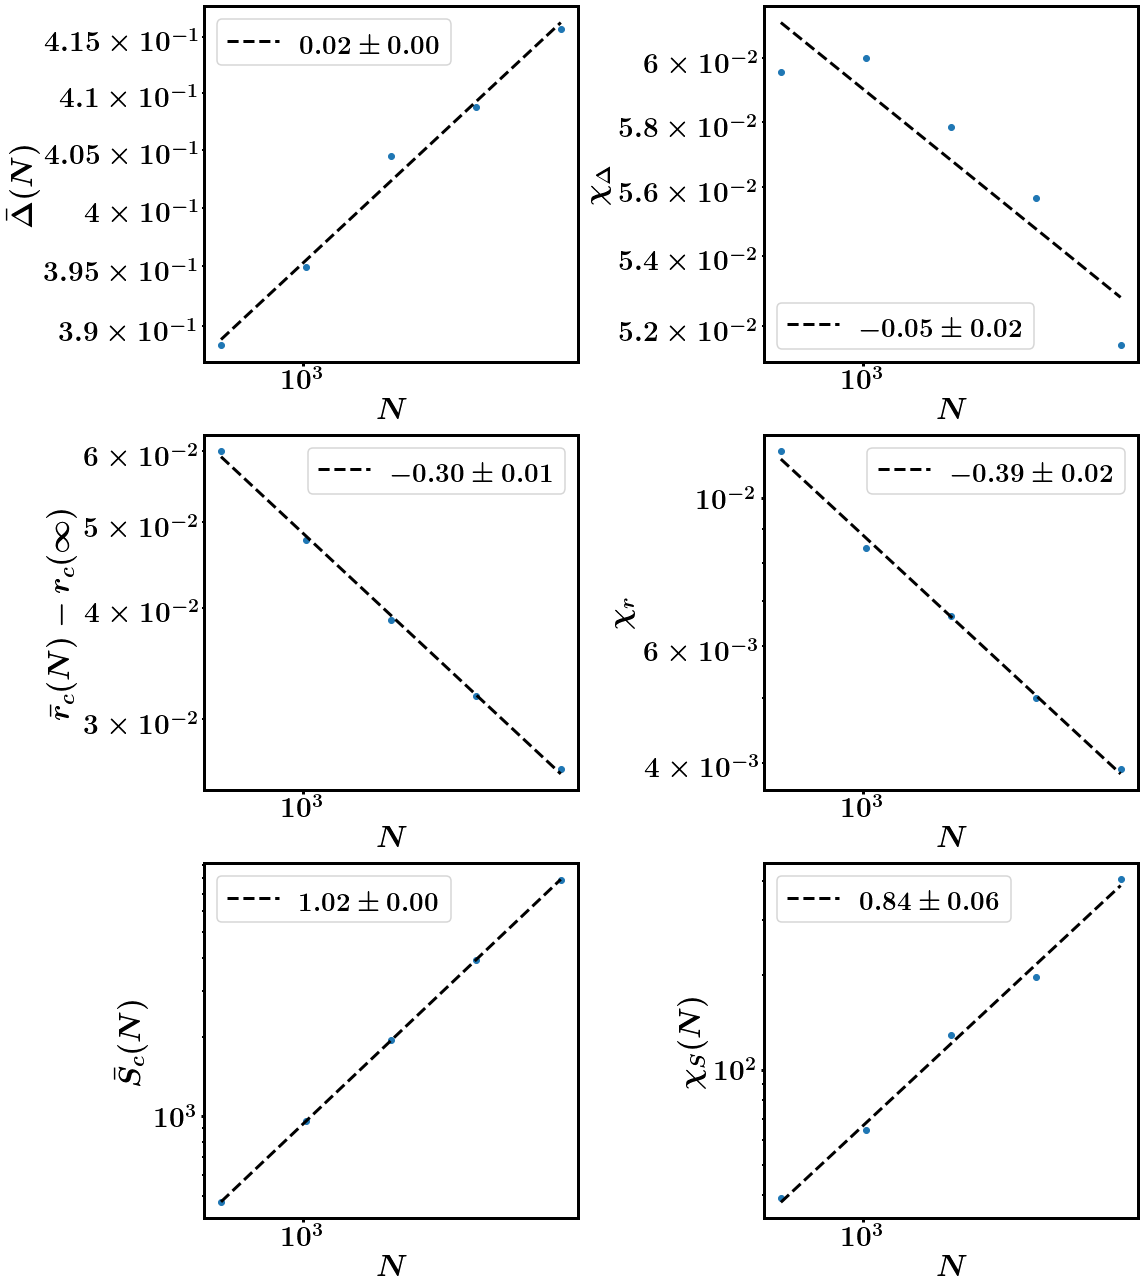

In [33]:
if net_type == 'Lattice':
    X = np.sqrt(sizes)
    str_size = 'L'
else:
    X = sizes
    str_size = 'N'
    

ncols = 2
nrows = 3
fig, axes = plt.subplots(figsize=(8*ncols, 6*nrows), ncols=ncols, nrows=nrows)

for ax in axes.flatten():
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel(r'${{{}}}$'.format(str_size))
    
ax = axes[0][0]
ax.set_ylabel(r'$\bar{\Delta}(N)$')
Y = all_mean_values[:,1]
Y_pred, slope, y_err = getLinearReg(X, Y)
ax.plot(X, Y, 'o')
ax.plot(X, Y_pred, '--', color='k', label=r'${{{:.2f}}}\pm{{{:.2f}}}$'.format(slope, y_err))

ax = axes[0][1]
ax.set_ylabel(r'$\chi_{\Delta}$')
Y = all_std_values[:,1]
Y_pred, slope, y_err = getLinearReg(X, Y)
ax.plot(X, Y, 'o')
ax.plot(X, Y_pred, '--', color='k', label=r'${{{:.2f}}}\pm{{{:.2f}}}$'.format(slope, y_err))

ax = axes[1][0]
ax.set_ylabel(r'$\bar{r}_c(N) - r_c(\infty)$')
ax.set_xlabel(r'$N$')
rc = 0
if attack == 'Ran' and net_type == 'ER':
    rc = 1/3.5
Y = all_mean_values[:,0] - rc
Y_pred, slope, y_err = getLinearReg(X, Y)
ax.plot(X, Y, 'o')
ax.plot(X, Y_pred, '--', color='k', label=r'${{{:.2f}}}\pm{{{:.2f}}}$'.format(slope, y_err))

ax = axes[1][1]
ax.set_ylabel(r'$\chi_{r}$')
Y = all_std_values[:,0]
Y_pred, slope, y_err = getLinearReg(X, Y)
ax.plot(X, Y, 'o')
ax.plot(X, Y_pred, '--', color='k', label=r'${{{:.2f}}}\pm{{{:.2f}}}$'.format(slope, y_err))


ax = axes[2][0]
ax.set_ylabel(r'$\bar{S}_c(N)$')
Y = all_mean_values[:,2]
Y_pred, slope, y_err = getLinearReg(X, Y)
ax.plot(X, Y, 'o')
ax.plot(X, Y_pred, '--', color='k', label=r'${{{:.2f}}}\pm{{{:.2f}}}$'.format(slope, y_err))


ax = axes[2][1]
ax.set_ylabel(r'$\chi_{S}(N)$')
Y = all_std_values[:,2]
Y_pred, slope, y_err = getLinearReg(X, Y)
ax.plot(X, Y, 'o')
ax.plot(X, Y_pred, '--', color='k', label=r'${{{:.2f}}}\pm{{{:.2f}}}$'.format(slope, y_err))

for ax in axes.flatten():
    ax.legend()

plt.tight_layout()
fig_name = os.path.join(fig_dir, 'Fan2020_fig1_{}_{}'.format(net_type, attack))
plt.savefig(fig_name + '.png')
plt.savefig(fig_name + '.pdf')
plt.show()

### **Fig 2, Fan (2020)**

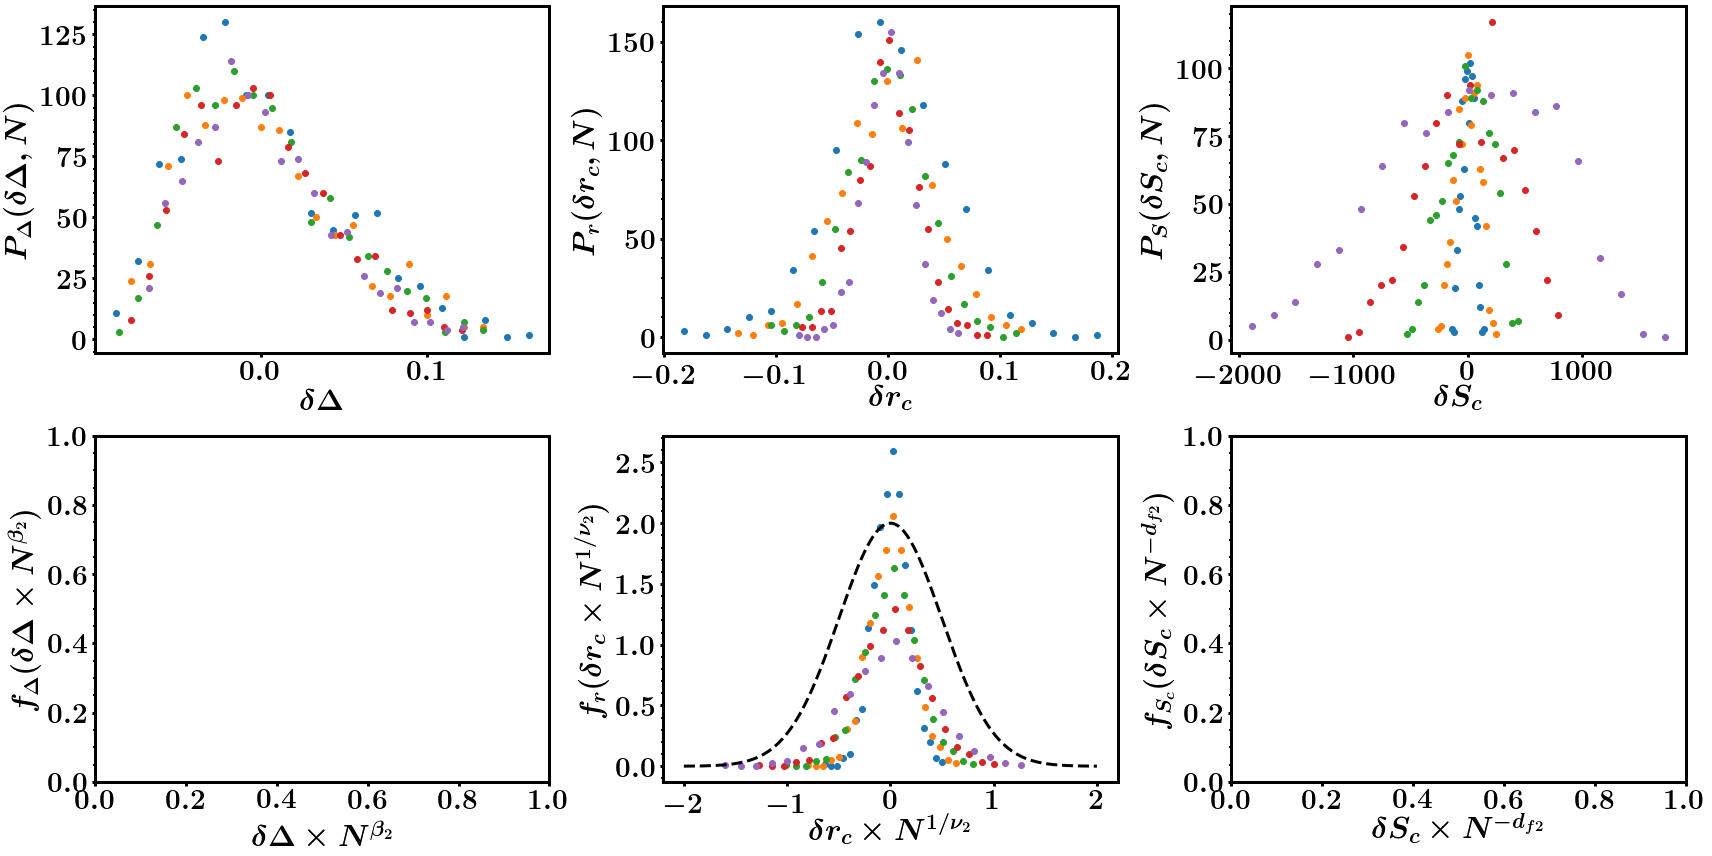

In [112]:
def f_r(z, zc, omega):
    return (1/omega) * np.exp(-(z-zc)**2/(2*omega**2))

if net_type == 'ER' and attack == 'Ran':
    rc = 1/3.5
    nu_2 = 3
    beta_2 = 1/3
    d_f2 = 2/3

bins = 20
ncols = 3
nrows = 2
fig, axes = plt.subplots(figsize=(8*ncols,6*nrows), ncols=ncols, nrows=nrows)

axes[0][0].set_xlabel(r'$\delta \Delta$')
axes[0][0].set_ylabel(r'$P_{\Delta}(\delta \Delta, N)$')
axes[1][0].set_xlabel(r'$\delta \Delta\times N^{\beta_2}$')
axes[1][0].set_ylabel(r'$f_{\Delta}(\delta \Delta \times N^{\beta_2})$')

axes[0][1].set_xlabel(r'$\delta r_c$')
axes[0][1].set_ylabel(r'$P_{r}(\delta r_c, N)$')
axes[1][1].set_xlabel(r'$\delta r_c\times N^{1/\nu_2}$')
axes[1][1].set_ylabel(r'$f_{r}(\delta r_c \times N^{1/\nu_2})$')

axes[0][2].set_xlabel(r'$\delta S_c$')
axes[0][2].set_ylabel(r'$P_{S}(\delta S_c, N)$')
axes[1][2].set_xlabel(r'$\delta S_c\times N^{-d_{f2}}$')
axes[1][2].set_ylabel(r'$f_{S_c}(\delta S_c \times N^{-d_{f2}})$')

index = [1, 0, 2]

for i, ax in enumerate(axes[0]):
    for size in sizes:
        freq, bin_edges = np.histogram(fluctuations[size][:,index[i]], bins=bins)
        bin_centers = (bin_edges[1:] + bin_edges[:-1]) / 2
        ax.plot(bin_centers, freq, 'o')
        

ax = axes[1][1]
for size in sizes:
    freq, bin_edges = np.histogram(
        fluctuations[N][:,0] * size**(1/nu_2), bins=bins, density=True
    )
    bin_centers = (bin_edges[1:] + bin_edges[:-1]) / 2
    #ax.plot(bin_centers * size**(1/nu_2), freq, 'o')
    ax.plot(bin_centers, freq, 'o')

        
ax = axes[1][1]
X = np.linspace(-2, 2, 10000)
#zc = rc * size**(1/nu)
omega = 0.5
F = lambda x: f_r(x, rc, omega)
ax.plot(X, F(X), '--', color='k')
        
plt.tight_layout()
fig_name = os.path.join(fig_dir, 'Fan2020_fig2_{}_{}'.format(net_type, attack))
plt.savefig(fig_name + '.png')
plt.savefig(fig_name + '.pdf')
plt.show()

In [34]:
nseeds_per_size = {
    128: 1000,
    256: 1000,
    512: 1000,
    1024: 1000,
    2048: 1000,
    4096: 1000,
    8192: 1000,
    16384: 100
}

sizes = [128, 256, 512, 1024, 2048, 4096, 8192, 16384]
l_values = np.arange(2, 100)
attacks = ['BtwU'] + ['BtwU_cutoff{}'.format(l) for l in l_values]
rc_values = {}
rc_values_std = {}
for size in sizes:
    print(size)
    nseeds = nseeds_per_size[size]
    rc_values[size] = []
    rc_values_std[size] = []
    for attack in attacks:
        #print(attack)
        try:
            delta_values = load_delta(net_type, size, param, attack)
            rc = delta_values[:,0].mean(axis=0)
            rc_std = delta_values[:,0].std(axis=0) / np.sqrt(delta_values.shape[0]-1)
            rc_values[size].append(rc)
            rc_values_std[size].append(rc_std)
        except:
            rc_values[size].append(np.NaN)
            rc_values_std[size].append(np.NaN)
    rc_values[size] = np.array(rc_values[size])
    rc_values_std[size] = np.array(rc_values_std[size])

#rc_values    

128
256
512
1024


/home/nahuel/anaconda3/envs/networks3/lib/python3.6/site-packages/ipykernel/__main__.py:17: UserWarning: loadtxt: Empty input file: "../networks/DT/DT_param/DT_param_N1024/Delta_values_BtwU_cutoff31_nSeeds1000.txt"
/home/nahuel/anaconda3/envs/networks3/lib/python3.6/site-packages/ipykernel/__main__.py:17: UserWarning: loadtxt: Empty input file: "../networks/DT/DT_param/DT_param_N1024/Delta_values_BtwU_cutoff32_nSeeds1000.txt"


2048
4096


/home/nahuel/anaconda3/envs/networks3/lib/python3.6/site-packages/ipykernel/__main__.py:17: UserWarning: loadtxt: Empty input file: "../networks/DT/DT_param/DT_param_N4096/Delta_values_BtwU_cutoff31_nSeeds100.txt"


8192


/home/nahuel/anaconda3/envs/networks3/lib/python3.6/site-packages/ipykernel/__main__.py:17: UserWarning: loadtxt: Empty input file: "../networks/DT/DT_param/DT_param_N8192/Delta_values_BtwU_cutoff17_nSeeds100.txt"
/home/nahuel/anaconda3/envs/networks3/lib/python3.6/site-packages/ipykernel/__main__.py:17: UserWarning: loadtxt: Empty input file: "../networks/DT/DT_param/DT_param_N8192/Delta_values_BtwU_cutoff18_nSeeds100.txt"
/home/nahuel/anaconda3/envs/networks3/lib/python3.6/site-packages/ipykernel/__main__.py:17: UserWarning: loadtxt: Empty input file: "../networks/DT/DT_param/DT_param_N8192/Delta_values_BtwU_cutoff19_nSeeds100.txt"
/home/nahuel/anaconda3/envs/networks3/lib/python3.6/site-packages/ipykernel/__main__.py:17: UserWarning: loadtxt: Empty input file: "../networks/DT/DT_param/DT_param_N8192/Delta_values_BtwU_cutoff21_nSeeds100.txt"
/home/nahuel/anaconda3/envs/networks3/lib/python3.6/site-packages/ipykernel/__main__.py:17: UserWarning: loadtxt: Empty input file: "../networks

16384


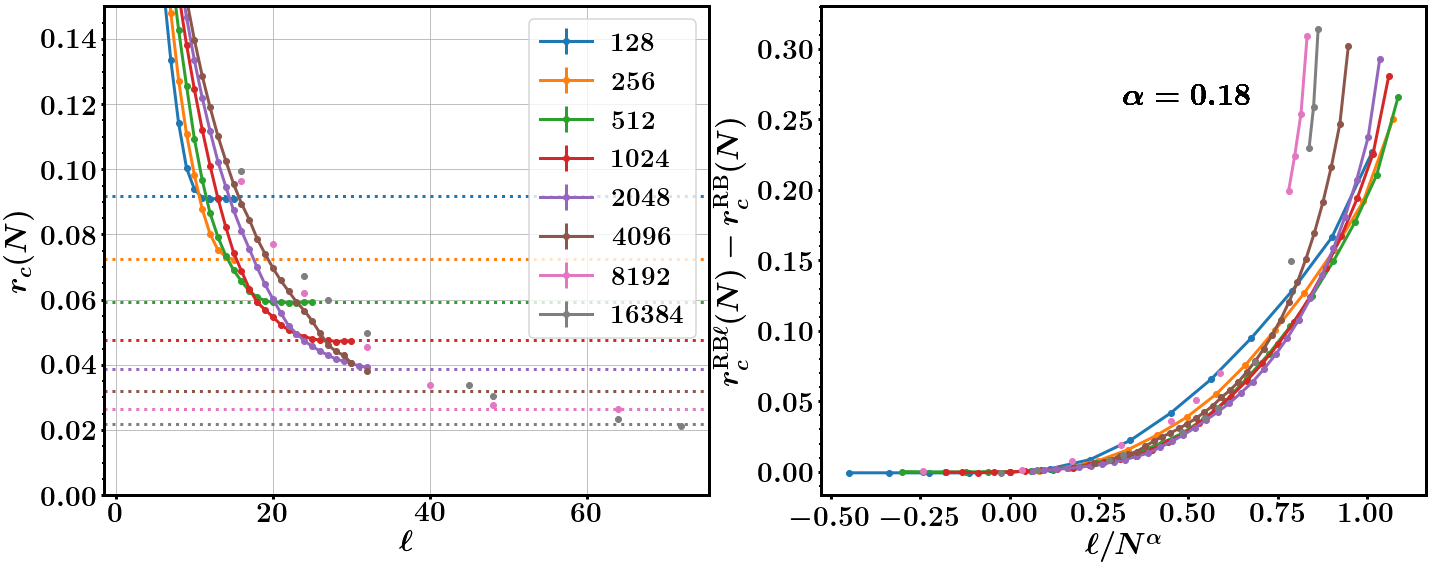

In [35]:
ncols = 2
nrows = 1
fig, axes = plt.subplots(figsize=(10*ncols,8*nrows), ncols=ncols, nrows=nrows)

ax = axes[0]
ax.grid(True)
ax.set_ylim(0, 0.15)
ax.set_xlabel(r'$\ell$')
ax.set_ylabel(r'$r_c(N)$')
for i, size in enumerate(sizes):    
    #ax.plot(l_values, rc_values[size][1:], 'o-', 
    #    color=colors[i], label=r'${{{}}}$'.format(size)
    #)
    ax.errorbar(l_values, rc_values[size][1:], rc_values_std[size][1:], marker='o',# 'o-', 
        color=colors[i], label=r'${{{}}}$'.format(size)
    )
    ax.axhline(rc_values[size][0], linestyle=':', color=colors[i])
ax.legend()

ax = axes[1]
ax.set_xlabel(r'$\ell/N^{\alpha}$')
ax.set_ylabel(r'$r_c^{\mathrm{RB}\ell}(N) - r_c^{\mathrm{RB}}(N)$')
#ax.set_yscale('log')
#ax.set_xscale('log')
for i, size in enumerate(sizes):

    e = 0.18
    ax.text(0.5, 0.8, r'$\alpha={{{:.2f}}}$'.format(e), fontsize=30, transform=ax.transAxes)
    #X = l_values / l_cutoff[size]
    X = (- l_values + l_cutoff[size])/size**0.45
    #X = l_values / size**e
    ax.plot(X, rc_values[size][1:]-rc_values[size][0], 'o-', 
        color=colors[i], label=r'${{{}}}$'.format(size)
    )
    
plt.tight_layout()
fig_name = os.path.join(fig_dir, 'peak_shifting_RBl_rc_{}'.format(net_type))
plt.savefig(fig_name + '.png')
plt.savefig(fig_name + '.pdf')

plt.tight_layout()
plt.show()

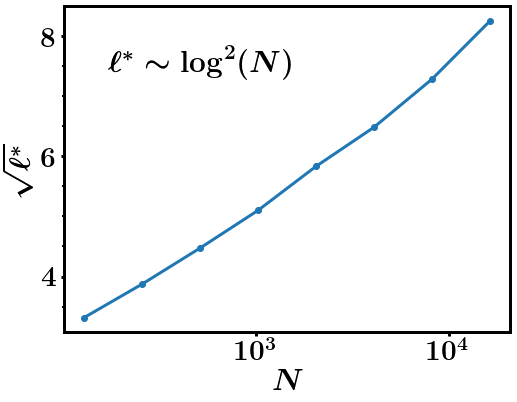

In [39]:
l_cutoff = {
    128: 11,
    256: 15,
    512: 20,
    1024: 26,
    2048: 34,
    4096: 42,
    8192: 53, 
    16384: 68
}

X = np.array(list(l_cutoff.keys()))
Y = np.sqrt(list(l_cutoff.values()))
fig, ax = plt.subplots(figsize=(8,6))
ax.set_xlabel(r'$N$')
ax.set_ylabel(r'$\sqrt{\ell^*}$')
ax.set_xscale('log')
#ax.set_yscale('log')
ax.plot(X, Y, 'o-')
ax.text(0.1, 0.8, r'$\ell^* \sim \log^2 (N)$', fontsize=30, transform=ax.transAxes)

plt.show()

In [37]:
networks = ['DT']#, 'Lattice']
attack = 'BtwU_cutoff2'
L = 256
N = L*L
size = {
    #'DT': 65536,
    #'DT': 16384,
    'DT': N,
    #'Lattice': 128
    'Lattice': L
}
param = 'param'

seeds = {
    'DT': 0,
    'Lattice': 0
}

connected = False

In [40]:
l_values = np.array([2**i for i in range(1, int(np.log2(L))+1)])
box_count_dict = {}
rho_values_dict = {}
for i, network in enumerate(networks):

    seed = seeds[network]
    
    g, max_pos, delta_max = load_delta_data(network, size[network], param, attack, seed)
    position = g.vs['position']
    attack_order = g['attack_order']
    
    h = g.copy()
    h.delete_vertices(attack_order[max_pos+1:])
    gcc = h.components(mode='WEAK').giant()
    
    if connected and network == 'DT':
        indices = gcc.vs['oi']
    else:
        indices = attack_order[:max_pos+1]
    
    print('Computing d_B')
    box_count_dict[network] = get_box_count(position, indices)
    
    print('Computing d_f')
    #rho_values = get_cluster_densities(position, indices, l_values, seeds=len(indices))
    rho_values = get_cluster_densities(position, indices, l_values, seeds=256)
    rho_values_dict[network] = [rho_values, l_values]
    
print(box_count_dict)
print(rho_values_dict)

Computing d_B
Computing d_f
{'DT': ([1, 4, 16, 64, 256, 1024, 4095, 14047], [256, 128, 64, 32, 16, 8, 4, 2])}
{'DT': [array([0.4453125 , 0.36621094, 0.34490967, 0.33798218, 0.32427597,
       0.30409241, 0.26154613, 0.19630516]), array([  2,   4,   8,  16,  32,  64, 128, 256])]}


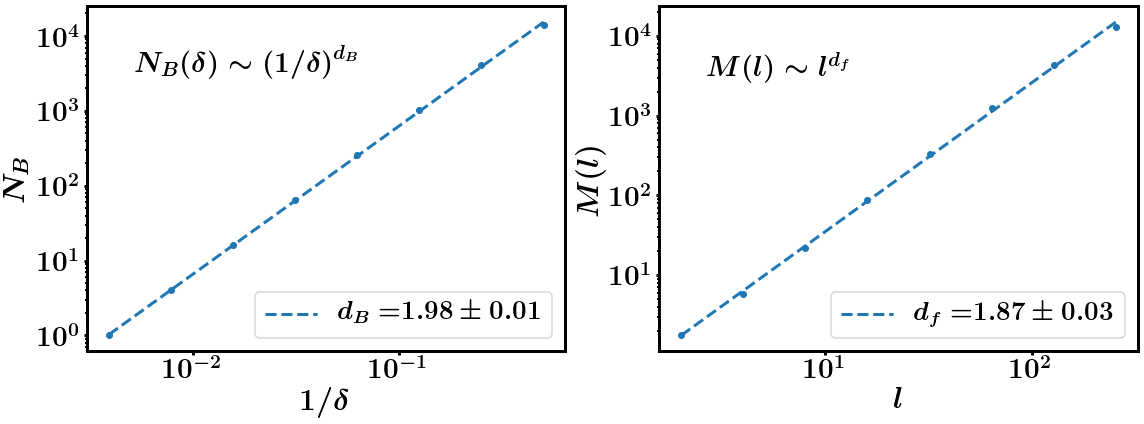

In [41]:
ncols = 2
nrows = 1
fig, axes = plt.subplots(figsize=(8*ncols,6*nrows), ncols=ncols, nrows=nrows)
ax = axes[0]
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$1/\delta$')
ax.set_ylabel(r'$N_B$')
#ax.text(0.1, 0.8, r'$N_B(\delta) \sim \delta^{-d_B}$', transform=ax.transAxes, fontsize=28)
ax.text(
    0.1, 0.8, r'$N_B(\delta) \sim \left(1/\delta\right)^{d_B}$', 
    transform=ax.transAxes, fontsize=28
)
for i, network in enumerate(networks):
    
    box_count_values, l_values = box_count_dict[network]
    X = 1/np.array(l_values)
    box_count_values = box_count_values
    Y_pred, slope, y_err = getLinearReg(X, box_count_values)
    
    ax.plot(X, box_count_values, 'o', color=colors[i])#, label=network)
    label = r'$d_B = $' + r'${{{:.2f}}}\pm{{{:.2f}}}$'.format(slope, y_err)
    ax.plot(X, Y_pred, '--', color=colors[i], label=label)

ax.legend(loc='lower right')


ax = axes[1]
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$l$')
#ax.set_ylabel(r'$M(l) / l^2$')
ax.set_ylabel(r'$M(l)$')
#ax.text(0.6, 0.9, r'$M(l) / l^2 \sim l^{d_f-d}$', transform=ax.transAxes, fontsize=28)
ax.text(0.1, 0.8, r'$M(l) \sim l^{d_f}$', transform=ax.transAxes, fontsize=28)
for i, network in enumerate(networks):
    
    rho_values, l_values = rho_values_dict[network]
    X = l_values
    Y = [rho*l**2 for (rho, l) in zip(rho_values, l_values)]
    Y_pred, slope, y_err = getLinearReg(X, Y)
    
    ax.plot(X, Y, 'o', color=colors[i])#, label=network)
    label = r'$d_f = $' + r'${{{:.2f}}}\pm{{{:.2f}}}$'.format(slope, y_err)
    ax.plot(X, Y_pred, '--', color=colors[i], label=label)

ax.legend(loc='lower right')

plt.tight_layout()
if connected:
    fig_name = os.path.join(fig_dir, 'df_L{}_{}_conn'.format(L, attack))
else:
    fig_name = os.path.join(fig_dir, 'df_L{}_{}'.format(L, attack))
plt.savefig(fig_name + '.png')
plt.savefig(fig_name + '.pdf')

plt.show()